In this notebook Im trying to understand and play around with the keras functional API to access more features of the model. Doing so I can access the output at each layer and perform transfer learning or visualise layers. 

In [32]:
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_v3 import InceptionV3
import matplotlib.pyplot as plt
from PIL import Image

# preloading weights
to get the model that we previously trained we can just load the model parameters into an identical one and compile it

In [2]:
# define model as done before
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [3]:
# load weights into model
model.load_weights("data/modelCheckpoints/_cats_dogs_model/")

In [4]:
# label data and evaluate model 
validation_dir = "data/dogs-vs-cats/validation/"

test_datagen  = ImageDataGenerator(rescale = 1/255)

validation_generator = test_datagen.flow_from_directory(validation_dir, batch_size=20, class_mode='binary', target_size=(150, 150))    
model.evaluate_generator(validation_generator, steps=50)

Found 1000 images belonging to 2 classes.


C:\Users\sherv\Anaconda3\envs\ML-Projects\lib\site-packages\tensorflow\python\keras\engine\training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.41489624977111816, 0.8479999899864197]

# Visualising Layers

Rewriting our previous `model` object within the functional API framework it would look like:
    
        inputs = tf.keras.Input(shape=(,150,150,3)) 
        dense1 = tf.keras.layers.Dense()(inputs)
        ...
        ouput = tf.keras.layers.Dense(1, activation='sigmoid')(last_hidden_layer)
        model = tf.keras.Model(inputs, output)
    
So up to now, our model had 1 output object and all of the layers before were truly hidden. Note that the `output` object is a single instance. To visualise this we want each layer to have an output. We can't do this with a `tf.keras.models.Sequential` so we will recreate the exact same model within the functional API context, but with outputs at each layer. To do this we will simply take the input and output objects from each layer (having an array of outputs), and construct our model:

        tf.keras.Model(inputs=model.input, outputs=[layer.output for layer in model.layers])

you can check the shape of the outputs against the model summary and see how they compare. Should be the same

In [5]:
# get layer outputs 
layer_outputs = [layer.output for layer in model.layers]
layer_names = [layer.name for layer in model.layers]

In [6]:
# build a model
visualisation_model = tf.keras.Model(inputs=model.input, outputs=layer_outputs) 

In [7]:
# import image 
path = "data/dogs-vs-cats/train/dogs/"
img = load_img(path+os.listdir(path)[1], target_size=(150,150))
test_img = img_to_array(img).reshape(1, 150, 150, 3) 
test_img /= 255

In [8]:
# run the image through the model
feature_maps = visualisation_model.predict(test_img) # gives output after each layer

C:\Users\sherv\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


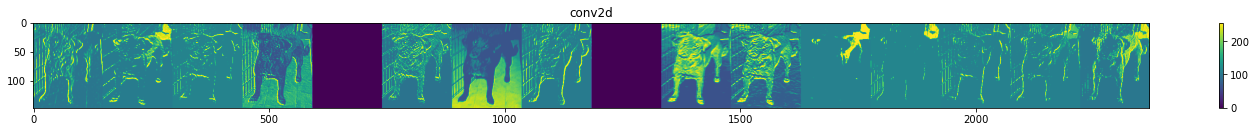

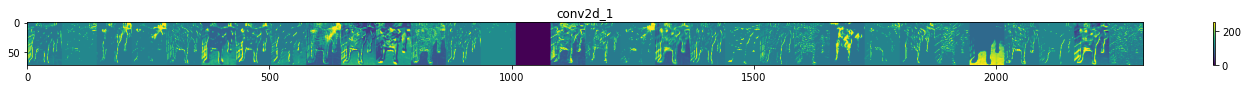

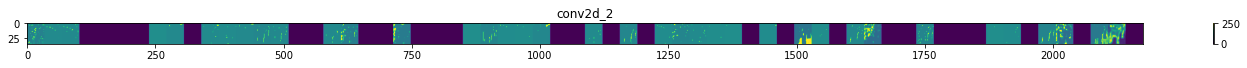

In [9]:

for layer_name, feature_map in zip(layer_names, feature_maps):
  if "conv" in layer_name: # only interested in visualising the conv layers
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size = feature_map.shape[1] # size of the image (PxP)
    # create a grid with P pixels high and P pixels wide and n_features times (side by side)
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      test_img  = feature_map[0, :, :, i]
      # why do we do the following?
      test_img -= test_img.mean()
      test_img /= test_img.std ()
      test_img *=  64
      test_img += 128
      test_img  = np.clip(test_img, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = test_img

    scale = 25. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    plt.colorbar()

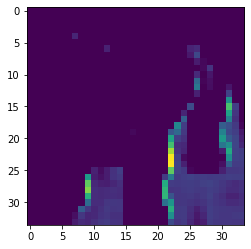

In [18]:
# the more convolutions you perform the more abstract the data becomes
plt.imshow(feature_maps[layer_names.index("conv2d_2")][0,:,:,-3])

# transfer learning
To perform transfer learning we can load the weights from the trained model

In [19]:
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, # the model has a dense layer at the top which we dont want to include
                                weights = "imagenet") 
# if you set the weights paramter to None you can load the weights in if you have them saved locally

# pre_trained_model.load_weights("data/modelCheckpoints/InceptionV3/")

In [20]:
for layer in pre_trained_model.layers:
    layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [21]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d_3[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [22]:
# we add our model to the end 

# Flatten the output layer to 1 dimension
flatten_layer = tf.keras.layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
my_dense = tf.keras.layers.Dense(1024, activation='relu')(flatten_layer)
# Add a dropout rate of 0.2
dropout_layer = tf.keras.layers.Dropout(0.2)(my_dense)                  
# Add a final sigmoid layer for classification
my_output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(dropout_layer)           

model = tf.keras.Model(pre_trained_model.input, my_output_layer) 

model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [23]:
# label data and evaluate model 
train_dir = "data/dogs-vs-cats/train/"
validation_dir = "data/dogs-vs-cats/validation/"

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen  = ImageDataGenerator(rescale = 1/255)

train_generator = train_datagen.flow_from_directory(train_dir, batch_size=20, class_mode='binary', target_size=(150, 150))   
validation_generator = test_datagen.flow_from_directory(validation_dir, batch_size=20, class_mode='binary', target_size=(150, 150))    

Found 24000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [28]:
# if transfer learning:

# create a callback based on accuracy
class AccuracyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') >= 0.8): 
      print("\nReached 80% accuracy. Cancelling training!")
      self.model.stop_training = True

# create a callback to save model weights
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath="data/modelCheckpoints/transfer-dogs-vs-cats/", save_weights_only=True, verbose=1)


history = model.fit(train_generator, 
                    validation_data=validation_generator, 
                    steps_per_epoch=1200, 
                    epochs=20, 
                    validation_steps=50, 
                    verbose=2 )
                  #  ,callbacks=[AccuracyCallback(), checkpoint_callback]) 

Epoch 1/20
1200/1200 - 492s - loss: 0.1780 - accuracy: 0.9374 - val_loss: 0.1470 - val_accuracy: 0.9650
Epoch 2/20
1200/1200 - 513s - loss: 0.1739 - accuracy: 0.9412 - val_loss: 0.1265 - val_accuracy: 0.9720
Epoch 3/20
1200/1200 - 461s - loss: 0.1701 - accuracy: 0.9452 - val_loss: 0.1173 - val_accuracy: 0.9700
Epoch 4/20
1200/1200 - 471s - loss: 0.1636 - accuracy: 0.9476 - val_loss: 0.1130 - val_accuracy: 0.9750
Epoch 5/20
1200/1200 - 482s - loss: 0.1548 - accuracy: 0.9467 - val_loss: 0.1670 - val_accuracy: 0.9610
Epoch 6/20
1200/1200 - 459s - loss: 0.1481 - accuracy: 0.9496 - val_loss: 0.1058 - val_accuracy: 0.9720
Epoch 7/20
1200/1200 - 483s - loss: 0.1502 - accuracy: 0.9491 - val_loss: 0.1238 - val_accuracy: 0.9710
Epoch 8/20
1200/1200 - 465s - loss: 0.1377 - accuracy: 0.9522 - val_loss: 0.1124 - val_accuracy: 0.9710
Epoch 9/20
1200/1200 - 465s - loss: 0.1440 - accuracy: 0.9503 - val_loss: 0.1015 - val_accuracy: 0.9730
Epoch 10/20
1200/1200 - 434s - loss: 0.1444 - accuracy: 0.9492 -

In [62]:
model.save_weights(filepath="data/modelCheckpoints/transfer-dogs-vs-cats/")

<Figure size 432x288 with 0 Axes>

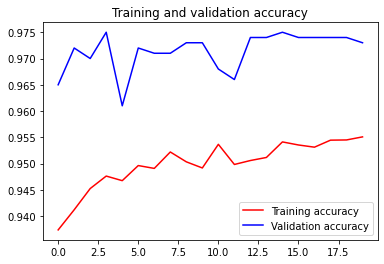

<Figure size 432x288 with 0 Axes>

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()


In [59]:
test_path = "data/rock-paper-sissor/test/"
images = [np.array(Image.open(test_path+img).resize((150,150)).getdata())
         for img in os.listdir(test_path)]


In [61]:
# model.predict(images[0])
images[0].shape

(22500, 4)